In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as d

In [11]:
df = pd.read_csv("data/24-25.csv")

In [12]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,F1,16/08/2024,19:45,Le Havre,Paris SG,1,4,A,0,1,...,1.93,2.00,1.95,1.97,1.95,2.02,1.89,1.95,1.95,2.02
1,F1,17/08/2024,16:00,Brest,Marseille,1,5,A,1,3,...,1.89,2.04,1.91,2.02,1.91,2.08,1.85,2.01,1.90,2.09
2,F1,17/08/2024,18:00,Reims,Lille,0,2,A,0,1,...,2.10,1.70,2.14,1.81,2.14,1.85,2.07,1.80,2.13,1.86
3,F1,17/08/2024,20:00,Monaco,St Etienne,1,0,H,1,0,...,2.00,1.93,2.00,1.93,2.00,2.01,1.95,1.91,1.95,2.00
4,F1,18/08/2024,14:00,Auxerre,Nice,2,1,H,1,1,...,1.82,2.11,1.82,2.13,1.83,2.17,1.77,2.10,1.84,2.16


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Columns: 119 entries, Div to BFECAHA
dtypes: float64(96), int64(16), object(7)
memory usage: 284.6+ KB


# 1. Nettoyage et préparation des données

- Supprimer ou gérer les valeurs manquantes (NaN) pour les colonnes clés (scores, cotes, cartons, tirs)

In [22]:
df.isnull().sum()

Div            0
Date           0
Time           0
HomeTeam       0
AwayTeam       0
              ..
PointsHome     0
PointsAway     0
TotalPoints    0
HomeResult     0
AwayResult     0
Length: 127, dtype: int64

- Standardiser les noms d’équipes (éviter doublons ou variantes)

In [23]:
sorted(set(df['HomeTeam']) | set(df['AwayTeam']))

['Angers',
 'Auxerre',
 'Brest',
 'Le Havre',
 'Lens',
 'Lille',
 'Lyon',
 'Marseille',
 'Monaco',
 'Montpellier',
 'Nantes',
 'Nice',
 'Paris SG',
 'Reims',
 'Rennes',
 'St Etienne',
 'Strasbourg',
 'Toulouse']

- Convertir les colonnes de date en datetime pour faciliter les filtrages par période

In [24]:
date = pd.to_datetime(df['Date'], format="%d/%m/%Y")
print(date)

0     2024-08-16
1     2024-08-17
2     2024-08-17
3     2024-08-17
4     2024-08-18
         ...    
301   2025-05-17
302   2025-05-17
303   2025-05-17
304   2025-05-17
305   2025-05-17
Name: Date, Length: 306, dtype: datetime64[ns]


- Créer des colonnes dérivées
    - GoalDiff = HomeGoals - AwayGoals
    - TotalGoals = HomeGoals + AwayGoals
    - MatchResultBinary (optionnel)

In [25]:
df["GoalDiffHome"] = df["FTHG"] - df["FTAG"]
df["GoalDiffAway"] = df["FTAG"] - df["FTHG"]
df["TotalGoals"] = df["FTHG"] + df["FTAG"]
# df["AwayWin"] = np.where(df["FTR"] == "A", 1, 0)
# df.drop("GoalDiff", axis=1)
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BFECAHH,BFECAHA,GoalDiffHome,GoalDiffAway,TotalGoals,PointsHome,PointsAway,TotalPoints,HomeResult,AwayResult
0,F1,16/08/2024,19:45,Le Havre,Paris SG,1,4,A,0,1,...,1.95,2.02,-3,3,5,0,3,0,-1,1
1,F1,17/08/2024,16:00,Brest,Marseille,1,5,A,1,3,...,1.90,2.09,-4,4,6,0,3,0,-1,1
2,F1,17/08/2024,18:00,Reims,Lille,0,2,A,0,1,...,2.13,1.86,-2,2,2,0,3,0,-1,1
3,F1,17/08/2024,20:00,Monaco,St Etienne,1,0,H,1,0,...,1.95,2.00,1,-1,1,3,0,3,1,-1
4,F1,18/08/2024,14:00,Auxerre,Nice,2,1,H,1,1,...,1.84,2.16,1,-1,3,3,0,3,1,-1


# 2. Analyse de performance dynamique

**Objectif :** suivre l’évolution des équipes au fil de la saison

- Calculer les points cumulés par journée pour chaque équipe (`cumsum`)

In [19]:
# Créer une colonne "Points" pour chaque match
df["PointsHome"] = np.where(df["FTR"] == "H", 3,
                   np.where(df["FTR"] == "D", 1, 0))

df["PointsAway"] = np.where(df["FTR"] == "A", 3,
                   np.where(df["FTR"] == "D", 1, 0))

# Création DataFrame Home & Away
dfHome = pd.DataFrame({
    "Team": df["HomeTeam"],
    "GoalDiff": df["GoalDiffHome"],
    "Points": df["PointsHome"],
    "MatchDay": date
})

dfAway = pd.DataFrame({
    "Team": df["AwayTeam"],
    "GoalDiff": df["GoalDiffAway"],
    "Points": df["PointsAway"],
    "MatchDay": date
})

# Concaténer les 2 DataFrame
dfAll = pd.concat([dfHome, dfAway], ignore_index=True)

# Trier par équipe et par date
dfAll.sort_values(["Team", "MatchDay"], inplace = True)

# Calculer les points cumulés
df["TotalPoints"] = dfAll.groupby(["Team"])["Points"].cumsum()


# OPTIONNEL
# Grouper par équipe et sommer les points
dfRanking = dfAll.groupby("Team")["Points"].sum().reset_index()

# Trier par points décroissants
dfRanking = dfRanking.sort_values("Points", ascending=False)
print(dfRanking)

           Team  Points
12     Paris SG      84
7     Marseille      65
8        Monaco      61
5         Lille      60
11         Nice      60
16   Strasbourg      57
6          Lyon      57
4          Lens      52
2         Brest      50
1       Auxerre      42
17     Toulouse      42
14       Rennes      41
0        Angers      36
10       Nantes      36
3      Le Havre      34
13        Reims      33
15   St Etienne      30
9   Montpellier      16


- Tracer l’évolution du classement avec un **line plot** interactif

C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3840634124.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfAll["Rank"] = dfAll.groupby("MatchDay").apply(lambda x: x.sort_values(["CumPts", "CumGD"], ascending=[False, False]).assign(Rank=range(1, len(x)+1))).reset_index(level=0, drop=True)["Rank"]
C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3840634124.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPlot["Rank"] = dfPlot["Rank"].astyp

<Axes: xlabel='MatchDay', ylabel='Rank'>

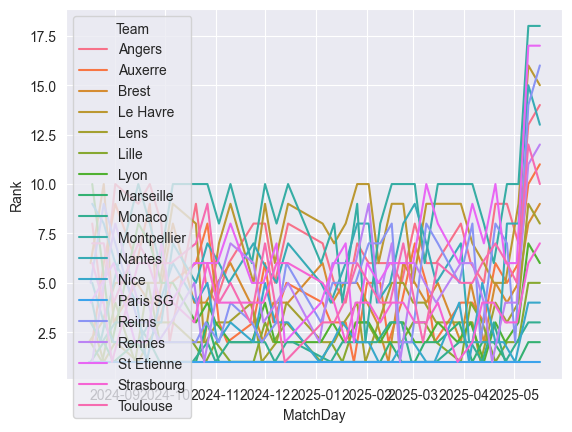

In [20]:
# (Optionnel mais recommandé) Tie-breaker
dfAll["CumPts"] = dfAll.groupby("Team")["Points"].cumsum()
dfAll["CumGD"] = dfAll.groupby("Team")["GoalDiff"].cumsum()

# Calculer le rang à chaque journée
dfAll.sort_values(["MatchDay", "CumPts", "CumGD"], ascending=[True, False, False], inplace=True)
dfAll["Rank"] = dfAll.groupby("MatchDay").apply(lambda x: x.sort_values(["CumPts", "CumGD"], ascending=[False, False]).assign(Rank=range(1, len(x)+1))).reset_index(level=0, drop=True)["Rank"]

# Préparer les données pour le tracé
dfPlot = dfAll[["MatchDay", "Team", "Rank"]]
dfPlot["Rank"] = dfPlot["Rank"].astype(int)
dfPlot.sort_values(["Team", "MatchDay"], inplace=True)

# Tracer en interactif
sns.lineplot(data=dfPlot, x="MatchDay", y="Rank", hue="Team")

- Visualiser les séries de victoires/défaites via un **heatmap** des performances par journée

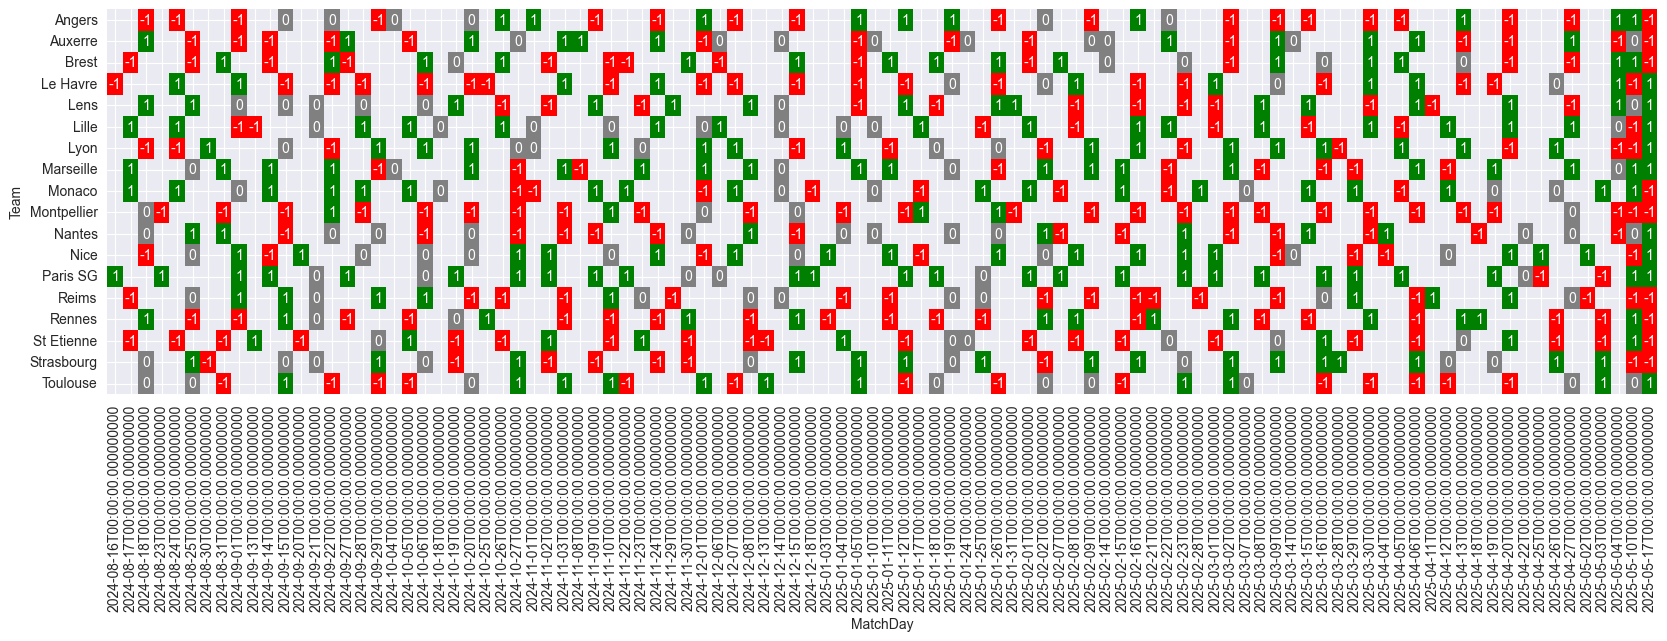

In [21]:
# Créer une colonne binaire par match et par équipe
conditions_home = [
    df["FTR"] == "H",   # victoire domicile
    df["FTR"] == "D",   # match nul
    df["FTR"] == "A"    # défaite domicile
]

conditions_away = [
    df["FTR"] == "A",   # victoire extérieur
    df["FTR"] == "D",   # match nul
    df["FTR"] == "H"    # défaite extérieur
]

choices_home = [1, 0, -1]   # 1 = win, 0 = draw, -1 = loss
choices_away = [1, 0, -1]

df["HomeResult"] = np.select(conditions_home, choices_home)
df["AwayResult"] = np.select(conditions_away, choices_away)

# Construire un DataFrame long
dfResultHome = pd.DataFrame({
    "Team": df["HomeTeam"],
    "ResultBinary": df["HomeResult"],
    "MatchDay": date
})

dfResultAway = pd.DataFrame({
    "Team": df["AwayTeam"],
    "ResultBinary": df["AwayResult"],
    "MatchDay": date
})

dfResultAll = pd.concat([dfResultHome, dfResultAway], ignore_index=True)
dfResultAll.sort_values(["Team", "MatchDay"], inplace=True)

# Pivot pour préparer la heatmap
dfHeatmap = dfResultAll.pivot(index="Team", columns="MatchDay", values="ResultBinary")

# Tracer la heatmap
plt.figure(figsize=(20, 5))  # largeur x hauteur en pouces
sns.heatmap(dfHeatmap, cmap=["red","grey","green"], cbar=False, annot=True)
plt.show()

# 3. Analyse des “big matches” et rivalités

**Objectif :** identifier les matchs clés de la saison

- Sélectionner les matchs entre équipes du top 5 ou top vs bottom

In [44]:
# Définir le top 5 et le bottom
print("Top 5 équipes :")
print(dfAll.groupby("Team")["CumPts"].max().nlargest(5))

print("\nBottom 5 équipes :")
print(dfAll.groupby("Team")["CumPts"].max().nsmallest(5))

# Isoler les équipes top et bottom
top_teams = dfAll.groupby("Team")["CumPts"].max().nlargest(5).index.tolist()
bottom_teams = dfAll.groupby("Team")["CumPts"].max().nsmallest(5).index.tolist()

# Filtrer les matchs dans le DataFrame principal
matchs_top_5 = df[
    (df["HomeTeam"].isin(top_teams)) & (df["AwayTeam"].isin(top_teams))
]

matchs_top_vs_bottom = df[
    ((df["HomeTeam"].isin(top_teams)) & (df["AwayTeam"].isin(bottom_teams))) |
    ((df["AwayTeam"].isin(top_teams)) & (df["HomeTeam"].isin(bottom_teams)))
]

print("\nTop names:", top_teams)
print("Exemples HomeTeam uniques:", df["HomeTeam"].unique()[:20])

# voir s'il y a des noms du top qui ne sont pas dans df['HomeTeam']
print("Missing in data:", set(top_teams) - set(df["HomeTeam"].unique()))

print("\nNb matchs top 5:", len(matchs_top_5))
print("Nb matchs top vs bottom:", len(matchs_top_vs_bottom))
matchs_top_5.head()



Top 5 équipes :
Team
Paris SG     84
Marseille    65
Monaco       61
Lille        60
Nice         60
Name: CumPts, dtype: int64

Bottom 5 équipes :
Team
Montpellier    16
St Etienne     30
Reims          33
Le Havre       34
Angers         36
Name: CumPts, dtype: int64

Top names: ['Paris SG', 'Marseille', 'Monaco', 'Lille', 'Nice']
Exemples HomeTeam uniques: ['Le Havre' 'Brest' 'Reims' 'Monaco' 'Auxerre' 'Angers' 'Montpellier'
 'Toulouse' 'Rennes' 'Paris SG' 'Lyon' 'Lille' 'St Etienne' 'Lens'
 'Nantes' 'Nice' 'Strasbourg' 'Marseille']
Missing in data: set()

Nb matchs top 5: 20
Nb matchs top vs bottom: 50


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BFECAHH,BFECAHA,GoalDiffHome,GoalDiffAway,TotalGoals,PointsHome,PointsAway,TotalPoints,HomeResult,AwayResult
26,F1,01/09/2024,19:45,Lille,Paris SG,1,3,A,0,2,...,1.90,2.08,-2,2,4,0,3,6,-1,1
28,F1,14/09/2024,16:00,Marseille,Nice,2,0,H,1,0,...,1.94,2.05,2,-2,2,3,0,10,1,-1
62,F1,06/10/2024,19:45,Nice,Paris SG,1,1,D,1,0,...,1.92,2.05,0,0,2,1,1,9,0,0
63,F1,18/10/2024,19:45,Monaco,Lille,0,0,D,0,0,...,2.18,1.84,0,0,0,1,1,20,0,0
78,F1,27/10/2024,16:00,Nice,Monaco,2,1,H,1,1,...,2.00,1.99,1,-1,3,3,0,13,1,-1


- Calculer les marges de victoire moyennes pour ces rencontres

In [55]:
# Créer une colonne marge de victoire
matchs_top_5["Margin"] = np.abs(matchs_top_5["FTHG"] - matchs_top_5["FTAG"])
matchs_top_vs_bottom["Margin"] = np.abs(matchs_top_vs_bottom["FTHG"] - matchs_top_vs_bottom["FTAG"])

# Calculer la moyenne
print("Marge moyenne - Top 5 vs Top 5 :", matchs_top_5["Margin"].mean())
print("Marge moyenne - Top vs Bottom :", matchs_top_vs_bottom["Margin"].mean())

Marge moyenne - Top 5 vs Top 5 : 1.45
Marge moyenne - Top vs Bottom : 1.96


C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\440671552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_5["Margin"] = np.abs(matchs_top_5["FTHG"] - matchs_top_5["FTAG"])
C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\440671552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_vs_bottom["Margin"] = np.abs(matchs_top_vs_bottom["FTHG"] - matchs_top_vs_bottom["FTAG"])


- Comparer la variance des cotes pour ces matchs (bookmakers moins d’accord)

C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3921501312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_5["variance_home"] = matchs_top_5[["B365H", "BWH", "BFH", "PSH", "WHH"]].var(axis=1)
C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3921501312.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_5["variance_away"] = matchs_top_5[["B365A", "BWA", "BFA", "PSA", "WHA"]].var(axis=1)
C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3921501312.py:12: SettingWit

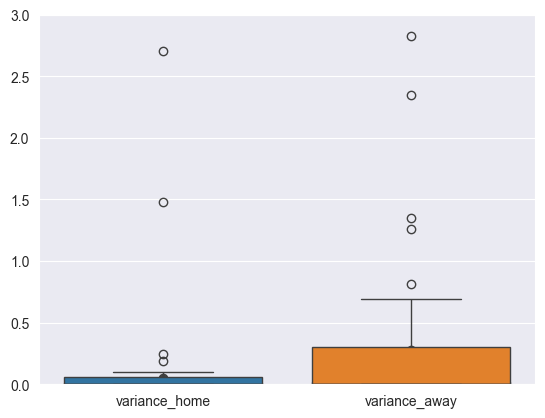

In [78]:
# Calculer la variance
matchs_top_5[["B365H", "BWH", "BFH", "PSH", "WHH"]].var(axis=1)
matchs_top_5[["B365A", "BWA", "BFA", "PSA", "WHA"]].var(axis=1)

matchs_top_vs_bottom[["B365H", "BWH", "BFH", "PSH", "WHH"]].var(axis=1)
matchs_top_vs_bottom[["B365A", "BWA", "BFA", "PSA", "WHA"]].var(axis=1)

# Ajouter une colonne
matchs_top_5["variance_home"] = matchs_top_5[["B365H", "BWH", "BFH", "PSH", "WHH"]].var(axis=1)
matchs_top_5["variance_away"] = matchs_top_5[["B365A", "BWA", "BFA", "PSA", "WHA"]].var(axis=1)

matchs_top_vs_bottom["variance_home"] = matchs_top_vs_bottom[["B365H", "BWH", "BFH", "PSH", "WHH"]].var(axis=1)
matchs_top_vs_bottom["variance_away"] = matchs_top_vs_bottom[["B365A", "BWA", "BFA", "PSA", "WHA"]].var(axis=1)

# Comparer les variances
matchs_top_5[["variance_home","variance_away"]].mean()
matchs_top_vs_bottom[["variance_home","variance_away"]].mean()

# Visualiser la dispersion des cotes
sns.boxplot(data=matchs_top_5[["variance_home","variance_away"]])
sns.boxplot(data=matchs_top_vs_bottom[["variance_home","variance_away"]])
plt.ylim(0, 3)  # limite de l'axe y entre 0 et 3
plt.show()

- Visualisation: scatter plot des scores vs cotes ou histogramme des marges

C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3336443179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_5["FavoriteOdd"] = np.where(matchs_top_5["FTR"] == "H", matchs_top_5["B365H"], matchs_top_5["B365A"])
C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3336443179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchs_top_vs_bottom["FavoriteOdd"] = np.where(matchs_top_vs_bottom["FTR"] == "H", matchs_top_vs_bottom["B365H"], matchs_top_vs_bottom["B365A"])
C:\Users\Vincent M

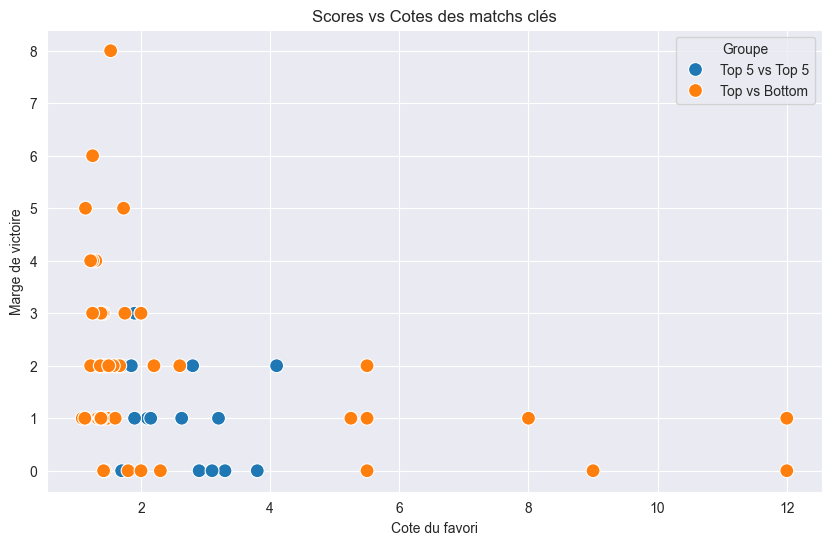

C:\Users\Vincent MY\AppData\Local\Temp\ipykernel_26276\3336443179.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Groupe")


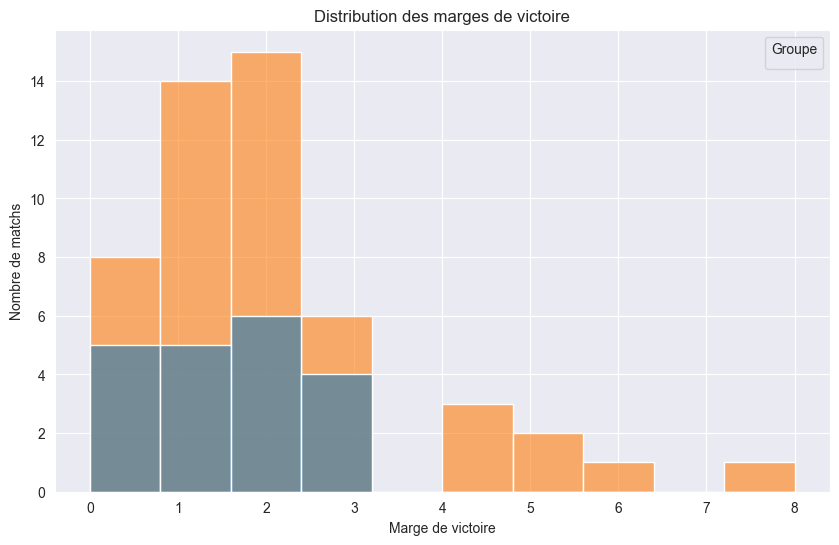

In [81]:
# Scatter plot des scores vs cotes
matchs_top_5["FavoriteOdd"] = np.where(matchs_top_5["FTR"] == "H", matchs_top_5["B365H"], matchs_top_5["B365A"])
matchs_top_vs_bottom["FavoriteOdd"] = np.where(matchs_top_vs_bottom["FTR"] == "H", matchs_top_vs_bottom["B365H"], matchs_top_vs_bottom["B365A"])

# Ajouter une colonne pour distinguer les groupes
matchs_top_5["Group"] = "Top 5 vs Top 5"
matchs_top_vs_bottom["Group"] = "Top vs Bottom"

# Combiner les deux DataFrames
df_plot = pd.concat([matchs_top_5, matchs_top_vs_bottom], ignore_index=True)

# Scatter plot avec couleur selon le groupe
plt.figure(figsize=(10,6))
sns.scatterplot(x="FavoriteOdd", y="Margin", hue="Group", data=df_plot, s=100)
plt.title("Scores vs Cotes des matchs clés")
plt.xlabel("Cote du favori")
plt.ylabel("Marge de victoire")
plt.legend(title="Groupe")
plt.show()


# Histogramme des marges
plt.figure(figsize=(10,6))
# Histogramme superposé
sns.histplot(data=df_plot, x="Margin", hue="Group", bins=10, kde=False, alpha=0.6)

plt.title("Distribution des marges de victoire")
plt.xlabel("Marge de victoire")
plt.ylabel("Nombre de matchs")
plt.legend(title="Groupe")
plt.show()

# 4. Analyse “fan insights”

**Objectif :** comprendre ce qu’un supporter ou analyste peut retirer des stats

- Taux de buts marqués après la mi-temps vs avant

- Cartons et fautes par match pour les équipes “agressives”

- Ratio tirs cadrés → buts pour identifier les équipes les plus efficaces

- Visualisation: radar chart par équipe ou bar plots comparatif

# 5. Exploration prédictive simplifiée

**Objectif :** mettre en évidence des patterns sans entraîner un modèle complexe

- Créer un score “favori probable” basé sur les cotes

- Vérifier si le favori “prévu” gagne réellement plus de 70 % du temps

- Visualiser la fiabilité des prédictions avec des **bar charts** ou **heatmaps**

# 6. Approche data storytelling

**Objectif :** raconter une histoire visuelle sur la saison

- “Qui a été la meilleure équipe à domicile vs extérieur ?” → bar chart

- “Les matchs les plus serrés” → scatter plot des scores

- “Les surprises de la saison” → points où la cote favori ne correspond pas au résultat

# 7. Manipulations Python typiques

- `groupby` par équipe ou période pour résumer les stats

- `merge` ou `concat` pour combiner domicile/extérieur si nécessaire

- Création de colonnes dérivées avec `apply` ou `np.where`

- Calcul de ratios et métriques : efficacité tirs → buts, cartons/match, over/under accuracy

# 8. Visualisations métier

- Classement final des équipes (bar chart)

- Bilan domicile vs extérieur (side-by-side bar chart)

- Heatmap de corrélation tirs / buts / cartons

- ROI d’une stratégie simple de pari (line chart ou bar chart)

- Comparaison probabilité implicite vs fréquence réelle (scatter plot + line)